# Titanic dataset
### TASK: create a model to predict if a passanger survives and implement the model in a web interface and save the requeste in postgresql

In [32]:
import pandas as pd
import numpy as np

#visual
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#Models
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
#Model helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV

## EDA

In [33]:
gender_sub = pd.read_csv("gender_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [36]:
train["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [37]:
train = train.dropna(subset=['Embarked'])
test.fillna(test["Fare"].median(), inplace=True)

In [38]:
train.fillna(train["Age"].median(), inplace= True)
test.fillna(test["Age"].median(), inplace= True)

In [39]:
train["FamilySize"] = train["SibSp"] + train["Parch"]
test["FamilySize"] = test["SibSp"] + test["Parch"]
train["IsAlone"] = 1
train["IsAlone"].iloc[train["FamilySize"]>1] = 0
test["IsAlone"] = 1
test["IsAlone"].iloc[test["FamilySize"]>1] = 0
train['FareBin'] = pd.qcut(train['Fare'], 4)
test['FareBin'] = pd.qcut(test['Fare'], 4)
train['AgeBin'] = pd.cut(train['Age'].astype(int), 5)
test['AgeBin'] = pd.cut(test['Age'].astype(int), 5)
train['FareBin'] = pd.qcut(train['Fare'], 4)
test['FareBin'] = pd.qcut(test['Fare'], 4)
train['Title'] = train['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
test['Title'] = test['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

stat_min = 10
title_names = (train['Title'].value_counts() < stat_min)
train['Title'] = train['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(train['Title'].value_counts())
print("-"*10)
title_names = (test['Title'].value_counts() < stat_min)
test['Title'] = test['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(test['Title'].value_counts())
print("-"*10)

mappings = {}
label = LabelEncoder()
train["Sex_Code"] = label.fit_transform(train["Sex"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
train["Embarked_Code"] = label.fit_transform(train["Embarked"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
train["Title_Code"] = label.fit_transform(train["Title"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
train["FareBin_Code"] = label.fit_transform(train["FareBin"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
train["AgeBin_Code"] = label.fit_transform(train["AgeBin"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
test["Sex_Code"] = label.fit_transform(test["Sex"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
test["Embarked_Code"] = label.fit_transform(test["Embarked"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
test["Title_Code"] = label.fit_transform(test["Title"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
test["FareBin_Code"] = label.fit_transform(test["FareBin"])
print(dict(zip(label.classes_, label.transform(label.classes_))))
test["AgeBin_Code"] = label.fit_transform(test["AgeBin"])
print(dict(zip(label.classes_, label.transform(label.classes_))))

Mr        517
Miss      181
Mrs       124
Master     40
Misc       27
Name: Title, dtype: int64
----------
Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64
----------
{'female': 0, 'male': 1}
{'C': 0, 'Q': 1, 'S': 2}
{'Master': 0, 'Misc': 1, 'Miss': 2, 'Mr': 3, 'Mrs': 4}
{Interval(-0.001, 7.896, closed='right'): 0, Interval(7.896, 14.454, closed='right'): 1, Interval(14.454, 31.0, closed='right'): 2, Interval(31.0, 512.329, closed='right'): 3}
{Interval(-0.08, 16.0, closed='right'): 0, Interval(16.0, 32.0, closed='right'): 1, Interval(32.0, 48.0, closed='right'): 2, Interval(48.0, 64.0, closed='right'): 3, Interval(64.0, 80.0, closed='right'): 4}
{'female': 0, 'male': 1}
{'C': 0, 'Q': 1, 'S': 2}
{'Master': 0, 'Misc': 1, 'Miss': 2, 'Mr': 3, 'Mrs': 4}
{Interval(-0.001, 7.896, closed='right'): 0, Interval(7.896, 14.454, closed='right'): 1, Interval(14.454, 31.472, closed='right'): 2, Interval(31.472, 512.329, closed='right'): 3}
{Interval(-0.

C:\Users\jpaul\AppData\Local\Temp\ipykernel_21448\4078204549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["IsAlone"].iloc[train["FamilySize"]>1] = 0
C:\Users\jpaul\AppData\Local\Temp\ipykernel_21448\4078204549.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["IsAlone"].iloc[test["FamilySize"]>1] = 0


In [40]:
train["FamilySize"]

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Name: FamilySize, Length: 889, dtype: int64

In [41]:
train["AgeBin_Code"].unique()

array([1, 2, 3, 0, 4])

In [42]:
train.drop(columns=["Cabin", "Ticket", "Name", "PassengerId"], inplace=True)
test.drop(columns=["Cabin", "Ticket", "Name", "PassengerId"], inplace=True)

In [43]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'FamilySize', 'IsAlone', 'FareBin', 'AgeBin', 'Title',
       'Sex_Code', 'Embarked_Code', 'Title_Code', 'FareBin_Code',
       'AgeBin_Code'],
      dtype='object')

C:\Users\jpaul\AppData\Local\Temp\ipykernel_21448\345565143.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), cmap="magma", annot=True)


<AxesSubplot: >

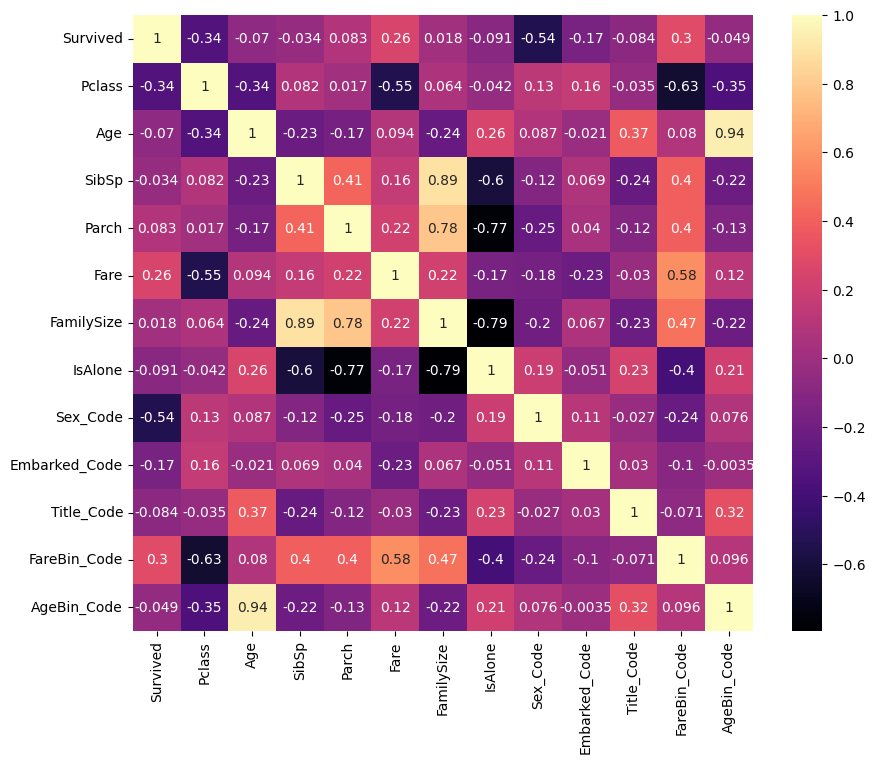

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), cmap="magma", annot=True)

high impact features are PClass, Sex and with littel impact Fare und Embarked_C sowie Embarked_S

<AxesSubplot: xlabel='Pclass'>

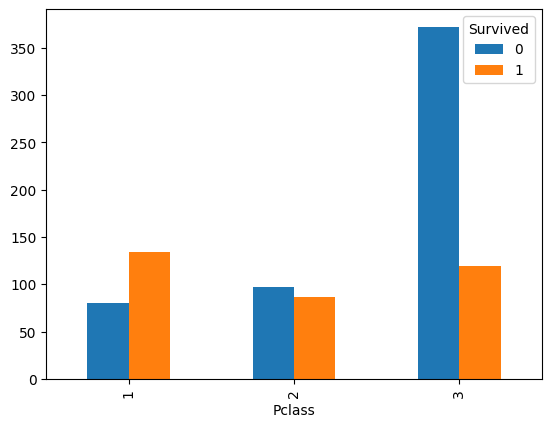

In [45]:
pd.crosstab(train['Pclass'], train['Survived']).plot(kind='bar')

<AxesSubplot: xlabel='Pclass'>

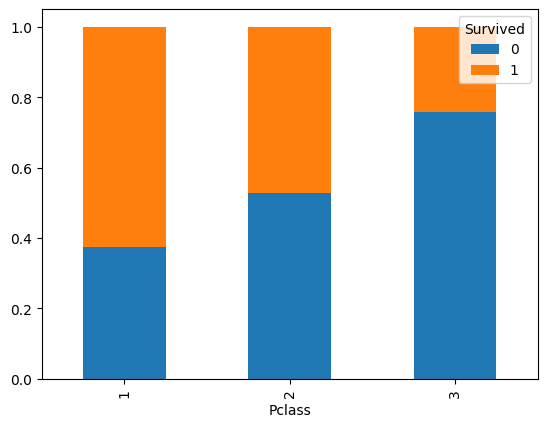

In [46]:
pd.crosstab(train["Pclass"], train["Survived"], normalize="index").plot(kind="bar", stacked=True)

<AxesSubplot: xlabel='Sex'>

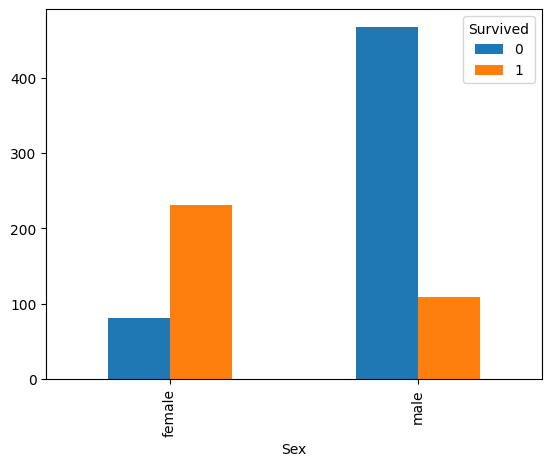

In [47]:
pd.crosstab(train["Sex"], train["Survived"]).plot(kind="bar")

<AxesSubplot: xlabel='Sex'>

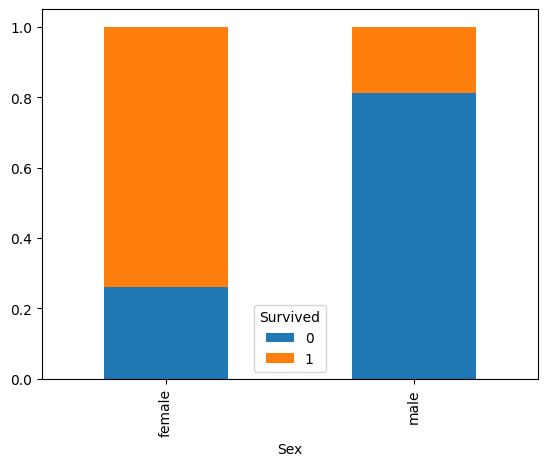

In [48]:
pd.crosstab(train["Sex"], train["Survived"], normalize="index").plot(kind="bar", stacked=True)

C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


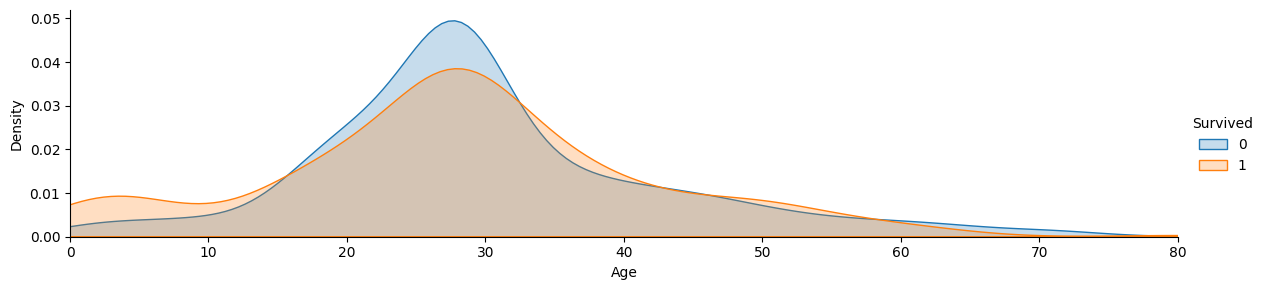

In [49]:
a = sns.FacetGrid(train, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train['Age'].max()))
a.add_legend()

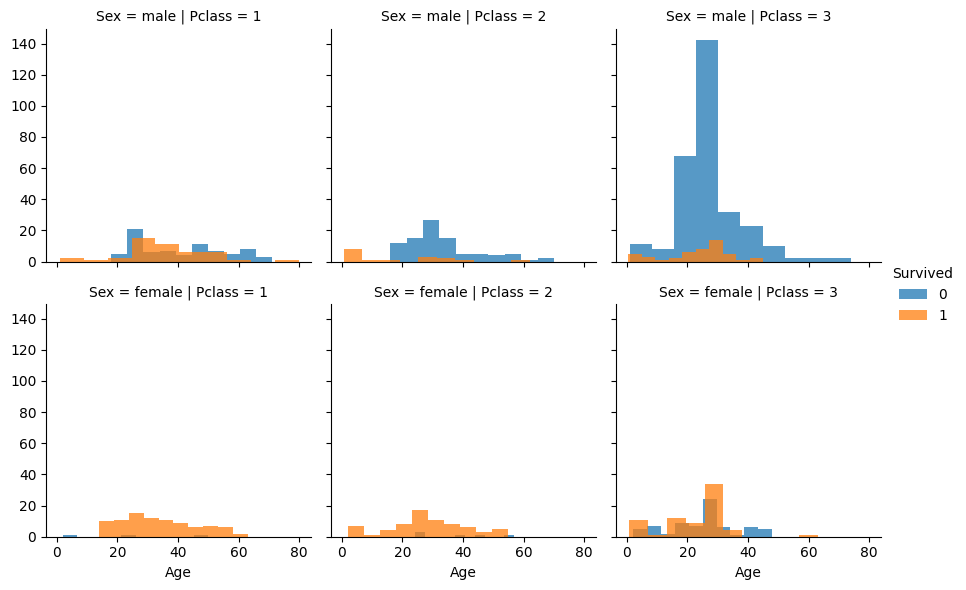

In [50]:
h = sns.FacetGrid(train, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

In [51]:
X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]

In [52]:
gender_sub.drop(columns=["PassengerId"], inplace=True)

In [53]:
X_test = test
y_test = gender_sub
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  418 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [54]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_combined = pd.concat([X_train, X_test], ignore_index=True)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_combined = pd.concat([y_train, y_test], ignore_index=True)
data = pd.concat([X_combined, y_combined], axis=1)

In [55]:
data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,FareBin,AgeBin,Title,Sex_Code,Embarked_Code,Title_Code,FareBin_Code,AgeBin_Code,Survived
0,3,male,22.0000,1,0,7.2500,S,1,1,"(-0.001, 7.896]","(16.0, 32.0]",Mr,1,2,3,0,1,0
1,1,female,38.0000,1,0,71.2833,C,1,1,"(31.0, 512.329]","(32.0, 48.0]",Mrs,0,0,4,3,2,1
2,3,female,26.0000,0,0,7.9250,S,0,1,"(7.896, 14.454]","(16.0, 32.0]",Miss,0,2,2,1,1,1
3,1,female,35.0000,1,0,53.1000,S,1,1,"(31.0, 512.329]","(32.0, 48.0]",Mrs,0,2,4,3,2,1
4,3,male,35.0000,0,0,8.0500,S,0,1,"(7.896, 14.454]","(32.0, 48.0]",Mr,1,2,3,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,3,male,14.4542,0,0,8.0500,S,0,1,"(7.896, 14.454]","(-0.076, 15.2]",Mr,1,2,3,1,0,0
1303,1,female,39.0000,0,0,108.9000,C,0,1,"(31.472, 512.329]","(30.4, 45.6]",Misc,0,0,1,3,2,1
1304,3,male,38.5000,0,0,7.2500,S,0,1,"(-0.001, 7.896]","(30.4, 45.6]",Mr,1,2,3,0,2,0
1305,3,male,14.4542,0,0,8.0500,S,0,1,"(7.896, 14.454]","(-0.076, 15.2]",Mr,1,2,3,1,0,0


In [56]:
#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data_xy =  Target + data_x
#define x variables for original w/bin features to remove continuous variables
data_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data_xy_bin = Target + data_x_bin
#define x and y variables for dummy features original
data_dummy = pd.get_dummies(data[data_x])
data_x_dummy = data_dummy.columns.tolist()
data_xy_dummy = Target + data_x_dummy

In [57]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost
    XGBClassifier()    
    ]

In [58]:
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=42)
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
MLA_predict = data["Survived"]
i = 0
for algo in MLA:
    MLA_name = algo.__class__.__name__
    MLA_compare.loc[i, "MLA Name"] = MLA_name
    MLA_compare.loc[i, "MLA Parameters"] = str(algo.get_params())
    cv_results = model_selection.cross_validate(algo, data[data_x_bin], data[Target], cv=cv_split, error_score="raise", return_train_score=True)
    MLA_compare.loc[i, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[i, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[i, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[i, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 #3 standard deviation from mean should capture 99.7% of subsets
    algo.fit(data[data_x_bin], data[Target])
    MLA_predict[MLA_name] = algo.predict(data[data_x_bin])
    i+=1
MLA_compare.sort_values(by=["MLA Test Accuracy Mean"], ascending = False, inplace=True)
MLA_compare

C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.885969,0.861832,0.032575,0.091898
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'estimator': None, 'l...",0.871046,0.858779,0.032251,0.069731
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.875893,0.858524,0.033484,0.071172
20,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.863265,0.857506,0.035967,0.001965
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.873214,0.857252,0.033353,0.089436
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.855357,0.854198,0.035975,0.002999
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': 'auto...",0.857143,0.853944,0.035999,0.002634
19,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.856633,0.853435,0.037115,0.00315
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.856633,0.853181,0.036298,0.003626
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.858163,0.852926,0.030876,0.086558


Text(0, 0.5, 'Algorithm')

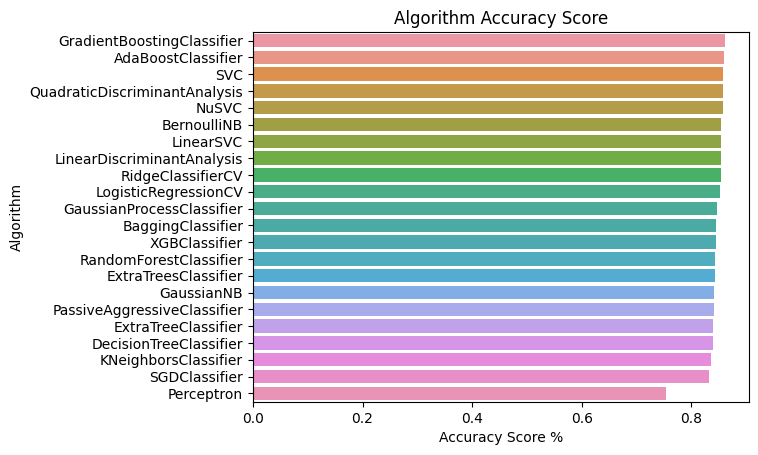

In [59]:
sns.barplot(MLA_compare, x="MLA Test Accuracy Mean", y="MLA Name")
plt.title("Algorithm Accuracy Score")
plt.xlabel("Accuracy Score %")
plt.ylabel("Algorithm")

In [60]:
# Daten aufteilen
X_combined = data[data_x_bin]
y_combined = data[Target]

# Ursprüngliche Trainings- und Testgrößen
train_size = len(y_train)
test_size = len(y_test)

# Daten zurück in Trainings- und Testsets aufteilen
X_train = X_combined.iloc[:train_size, :]
X_test = X_combined.iloc[train_size:, :]
y_train = y_combined.iloc[:train_size]
y_test = y_combined.iloc[train_size:]

# Überprüfen der Aufteilung
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (889, 7)
X_test shape: (418, 7)
y_train shape: (889, 1)
y_test shape: (418, 1)


In [61]:
top_5_models = MLA_compare.head(5)['MLA Name'].values
print("Top 5 Modelle:", top_5_models)


Top 5 Modelle: ['GradientBoostingClassifier' 'AdaBoostClassifier' 'SVC'
 'QuadraticDiscriminantAnalysis' 'NuSVC']


Training GradientBoostingClassifier...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Beste Parameter für GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Beste Score für GradientBoostingClassifier: 0.8346854567383991
Training AdaBoostClassifier...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Beste Parameter für AdaBoostClassifier: {'learning_rate': 0.1, 'n_estimators': 100}
Beste Score für AdaBoostClassifier: 0.8268075922046594
Training RandomForestClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Beste Parameter für RandomForestClassifier: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Beste Score für RandomForestClassifier: 0.8279375357074844
Training SVC...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Beste Parameter für SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Beste Score für SVC: 0.8301783787215132
Training NuSVC...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pack

Beste Parameter für NuSVC: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.5}
Beste Score für NuSVC: 0.8290484352186885
Training QuadraticDiscriminantAnalysis...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Beste Parameter für QuadraticDiscriminantAnalysis: {'reg_param': 0.0, 'tol': 0.0001}
Beste Score für QuadraticDiscriminantAnalysis: 0.8133180981400369


C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for ex

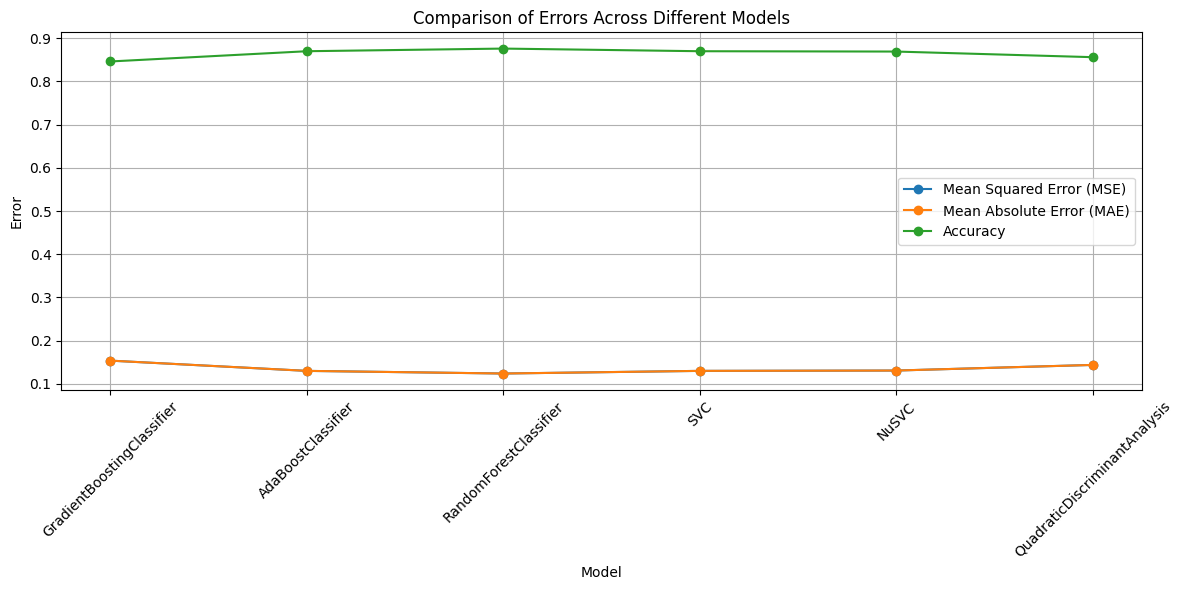

In [62]:
# Modelle und Parameter für GridSearchCV definieren
models = {
    'GradientBoostingClassifier': ensemble.GradientBoostingClassifier(),
    'AdaBoostClassifier': ensemble.AdaBoostClassifier(),
    'RandomForestClassifier': ensemble.RandomForestClassifier(),
    "SVC": svm.SVC(),
    "NuSVC": svm.NuSVC(),
    "QuadraticDiscriminantAnalysis": discriminant_analysis.QuadraticDiscriminantAnalysis(),
}

param_grids = {
    'GradientBoostingClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'NuSVC': {
        'nu': [0.1, 0.5, 0.9],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'QuadraticDiscriminantAnalysis': {
        'reg_param': [0.0, 0.1, 0.5],
        'tol': [1e-4, 1e-3, 1e-2]
    }
}

best_estimators = {}
values = {'Model': [], 'MSE': [], 'MAE': [], 'Accuracy': []}
for model_name in models:
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=models[model_name], param_grid=param_grids[model_name], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Beste Parameter und Score ausgeben
    print(f"Beste Parameter für {model_name}: {grid_search.best_params_}")
    print(f"Beste Score für {model_name}: {grid_search.best_score_}")
    
    # Besten Schätzer speichern
    best_estimators[model_name] = grid_search.best_estimator_

# Modelle mit den besten Parametern trainieren und Vorhersagen auf dem Testset machen
for model_name in best_estimators:
    best_model = best_estimators[model_name]
    best_model.fit(X_train, y_train)
    
    # Vorhersagen auf dem Testset
    y_pred = best_model.predict(data[data_x_bin])
    # Fehler berechnen
    mse = mean_squared_error(data[Target], y_pred)
    mae = mean_absolute_error(data[Target], y_pred)
    accuracy = accuracy_score(data[Target], y_pred)
    # Fehler in Dictionary speichern
    values['Model'].append(model_name)
    values['MSE'].append(mse)
    values['MAE'].append(mae)
    values["Accuracy"].append(accuracy)

values_df = pd.DataFrame(values)
plt.figure(figsize=(12,6))
plt.plot(values_df['Model'], values_df['MSE'], marker='o', label='Mean Squared Error (MSE)')
plt.plot(values_df['Model'], values_df['MAE'], marker='o', label='Mean Absolute Error (MAE)')
plt.plot(values_df["Model"], values_df["Accuracy"], marker='o', label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Comparison of Errors Across Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=5, random_state=42)
rf_model.fit(data[data_x_bin], data[Target])
joblib.dump(rf_model, "model.pkl")

C:\Users\jpaul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


['Random_Forest_model.pkl']

In [64]:
data_x_bin

['Sex_Code',
 'Pclass',
 'Embarked_Code',
 'Title_Code',
 'FamilySize',
 'AgeBin_Code',
 'FareBin_Code']

In [65]:
Target

['Survived']